In [1]:
%pylab inline
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn
import os, re

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_pickle('../data/kal_returnsDF.pkl')
symbolsDF = pd.read_pickle('../data/symbolsDF.pkl')
sectors = symbolsDF.sector.unique().tolist()

In [3]:
start, end = '2007-05-02', '2016-04-11'                        #variable here
datadir_name = '_'.join(('data', start, end))
datadir_path = ''.join(('../data/', datadir_name))

In [4]:
def get_symbol_results(symbol='GS'):
    df = pd.read_pickle(''.join((datadir_path, '/', symbol, '.pkl')))
    return df
df = get_symbol_results()

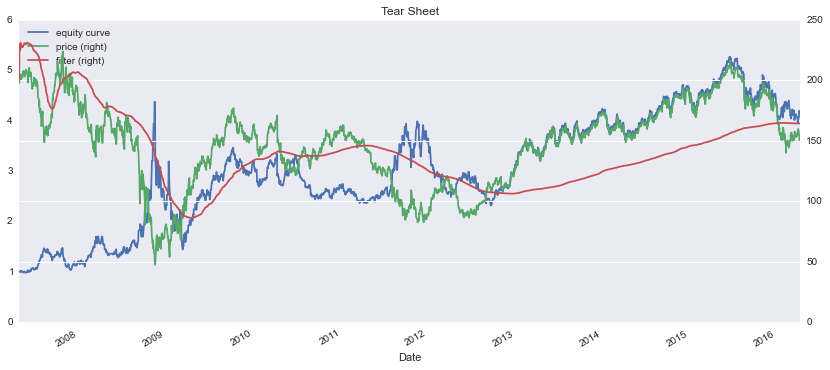

In [21]:
np.cumprod(df.kal_returns+1).plot(label="equity curve", legend=True, 
                                  title='Tear Sheet', figsize=(14,6))
df['Adj Close'].plot(secondary_y=True, label="price", legend=True)
df.kalman_predict.plot(secondary_y=True, label="filter", legend=True)

In [7]:
os.chdir('../GetBasicData/')
import smoothing_fns as sf

In [8]:
os.chdir('../SimulateTrades/')
import trade_logic as tl

In [131]:
def get_historical_positions_old(df, smoothcol, pos_colname, days_returning=1):
    df['resids'] = df['Adj Close']-df[smoothcol]
    df[pos_colname] = ((df['resids']>0)-.5)*2
    df.loc[df['resids'].isnull(), pos_colname] = 0
    df.loc[((df['resids']==pd.rolling_max(df['resids'], 5)).astype(int) + 
          (df['resids']>0).astype(int))==2, pos_colname]=0
    df.loc[((df['resids']==pd.rolling_min(df['resids'], 5)).astype(int) + 
          (df['resids']<0).astype(int))==2, pos_colname]=0
    while days_returning>1:
        df.loc[df[pos_colname].shift(1)==0, pos_colname]=0
        days_returning -= 1
    return df

def get_historical_positions(df, smoothcol, pos_colname):
    df['resids'] = df['Adj Close']-df[smoothcol]
    df[pos_colname] = ((df['resids']>0)-.5)*2
    df[pos_colname][df['resids'].isnull()] = 0
    df['change_sign'] = df.resids*df.resids.shift(1)<0
    
    m = []
    for i in range(df.shape[0]):
        if i==0:
            m.append(df.resids[i])
        elif df.change_sign[i] == True:
            m.append(0)
        elif df.resids[i]>m[-1]:
            m.append(df.resids[i])
        else:
            m.append(m[-1])
    df['max_'] = m
    m = []
    for i in range(df.shape[0]):
        if i==0:
            m.append(df.resids[i])
        elif df.change_sign[i] == True:
            m.append(0)
        elif df.resids[i]<m[-1]:
            m.append(df.resids[i])
        else:
            m.append(m[-1])
    df['min_'] = m
    
    df[pos_colname][((df['resids']==df.max_).astype(int) + (df['resids']>0).astype(int)) == 2] = 0
    df[pos_colname][((df['resids']==df.min_).astype(int) + (df['resids']<0).astype(int)) == 2] = 0
    return df

In [119]:
def play_with_Q(df, Q):
    xs, cov = sf.run(data = df, Q=Q)
    df['new_smooth_col'] = xs[:,0]
    df = get_historical_positions_old2(df, 'new_smooth_col', 'new_pos_col' ,  days_returning=3)
    df['new_returns'] = df['daily_rets']*df['new_pos_col']
    return df

In [122]:
df = play_with_Q(df, .000001)

In [132]:
def get_tear_sheet(df, Q, trade_logic, days_regr):
    xs, cov = sf.run(data = df, Q=Q)
    df['new_smooth_col'] = xs[:,0]
    if trade_logic=='old':
        df = get_historical_positions_old2(df, 'new_smooth_col',
                                           'new_pos_col' ,  days_returning=days_regr)
    if trade_logic=='new':
        df = get_historical_positions_old(df, 'new_smooth_col',
                                           'new_pos_col')
    df['new_returns'] = df['daily_rets']*df['new_pos_col']
    
    np.cumprod(df.new_returns+1).plot(label="equity curve", legend=True, 
                                      title='Tear Sheet', figsize=(14,6))
    df['Adj Close'].plot(secondary_y=True, label="price", legend=True)
    df.new_smooth_col.plot(secondary_y=True, label="filter", legend=True)
    show()

    timedelt= df.index[-1] - df.index[1]
    years = timedelt.days/365
    total_ret = np.cumprod(df.new_returns+1)[-10]**(1/years) - 1
    print('annual return: %s' %total_ret)
    var = np.std(df.new_returns)*np.sqrt(252)
    print('variance: %s' %var)
    print('sharpe: %s' %(total_ret/var))

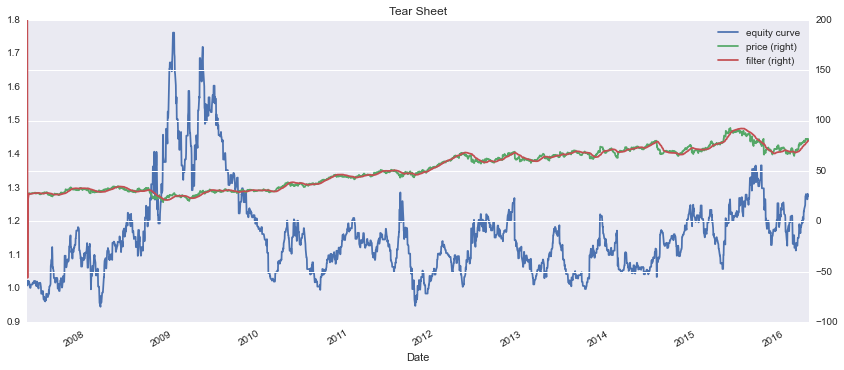

annual return: 0.0274736738167
variance: 0.23702193904
sharpe: 0.115911944388


In [139]:
get_tear_sheet(df, .00001, 'old', 1)

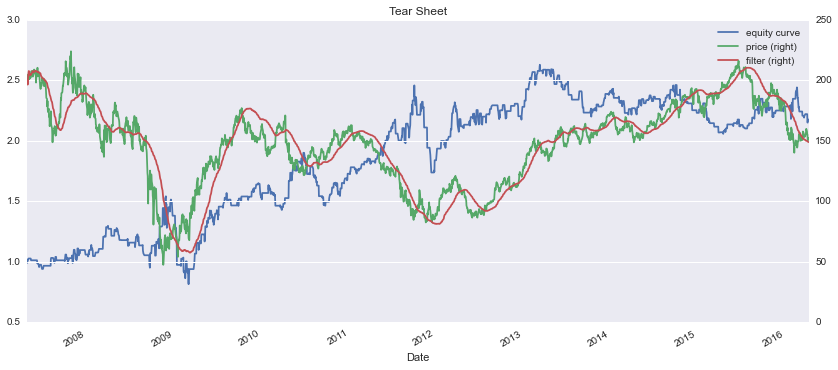

annual return: 0.093199131259
variance: 0.253902399431
sharpe: 0.367066760566


In [123]:
np.cumprod(df.new_returns+1).plot(label="equity curve", legend=True, 
                                  title='Tear Sheet', figsize=(14,6))
df['Adj Close'].plot(secondary_y=True, label="price", legend=True)
df.new_smooth_col.plot(secondary_y=True, label="filter", legend=True)
show()

timedelt= df.index[-1] - df.index[1]
years = timedelt.days/365
total_ret = np.cumprod(df.new_returns+1)[-10]**(1/years) - 1
print('annual return: %s' %total_ret)
var = np.std(df.new_returns)*np.sqrt(252)
print('variance: %s' %var)
print('sharpe: %s' %(total_ret/var))

# Portfolio

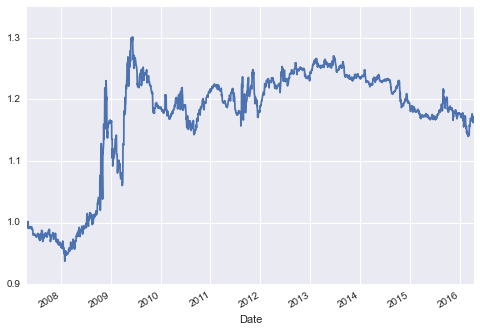

In [124]:
bigDF = pd.DataFrame()
for symbol in symbolsDF.index:
    df = get_symbol_results(symbol)
    bigDF[symbol] = play_with_Q(df, .000001).new_returns
np.cumprod(bigDF.mean(axis=1)+1).plot()

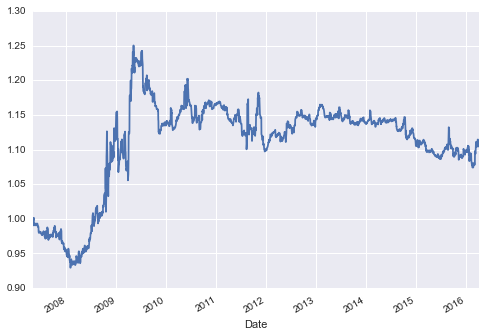

In [125]:
bigDF = pd.DataFrame()
for symbol in symbolsDF.index:
    df = get_symbol_results(symbol)
    bigDF[symbol] = play_with_Q(df, .00001).new_returns
np.cumprod(bigDF.mean(axis=1)+1).plot()

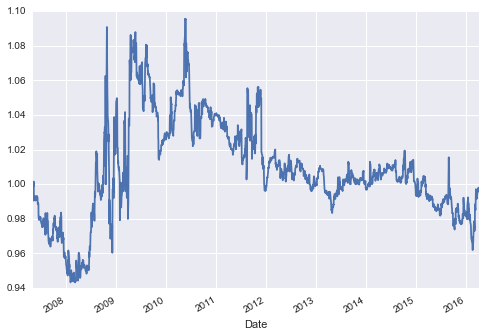

In [126]:
bigDF = pd.DataFrame()
for symbol in symbolsDF.index:
    df = get_symbol_results(symbol)
    bigDF[symbol] = play_with_Q(df, .0001).new_returns
np.cumprod(bigDF.mean(axis=1)+1).plot()

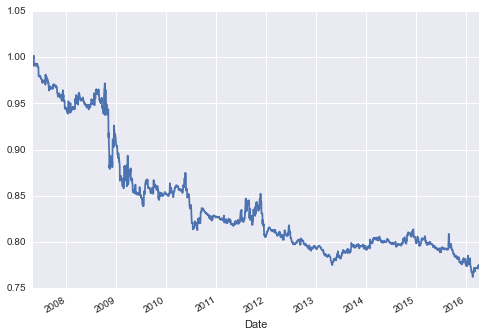

In [127]:
bigDF = pd.DataFrame()
for symbol in symbolsDF.index:
    df = get_symbol_results(symbol)
    bigDF[symbol] = play_with_Q(df, .001).new_returns
np.cumprod(bigDF.mean(axis=1)+1).plot()

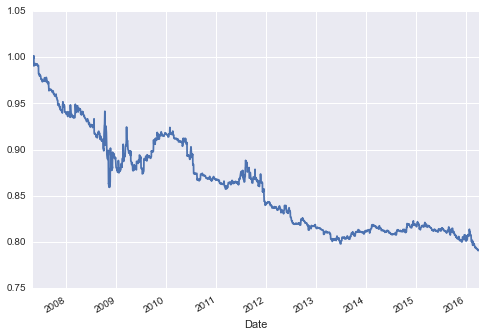

In [128]:
bigDF = pd.DataFrame()
for symbol in symbolsDF.index:
    df = get_symbol_results(symbol)
    bigDF[symbol] = play_with_Q(df, .01).new_returns
np.cumprod(bigDF.mean(axis=1)+1).plot()

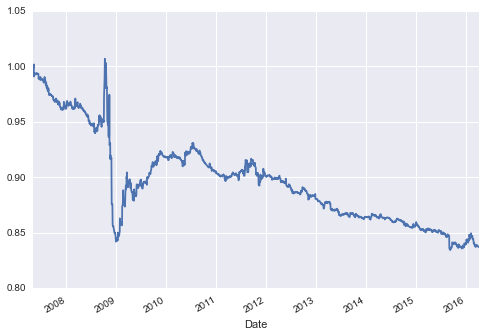

In [129]:
bigDF = pd.DataFrame()
for symbol in symbolsDF.index:
    df = get_symbol_results(symbol)
    bigDF[symbol] = play_with_Q(df, .1).new_returns
np.cumprod(bigDF.mean(axis=1)+1).plot()

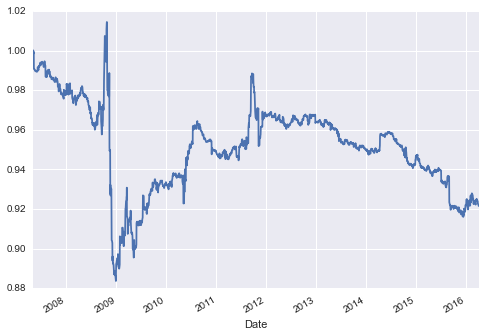

In [130]:
bigDF = pd.DataFrame()
for symbol in symbolsDF.index:
    df = get_symbol_results(symbol)
    bigDF[symbol] = play_with_Q(df, 1).new_returns
np.cumprod(bigDF.mean(axis=1)+1).plot()